# COVID-19 Tweets EDA and Sentimental Analysis

In this notebook I have performed the following:

### EDA:

* Processing of user locations to get only country names.
* Trend of tweet count over the period of time for top 4 countries.
* Plotting of top countries, users, source of tweet based on the number of tweets.
* Word cloud presentation of hashtags and tweets.


### Sentimental Analysis:

Since this dataset does not have information regarding the sentiment of tweets, I have used the [Covid 19 Indian Sentiments on covid19 and lockdown](https://www.kaggle.com/surajkum1198/twitterdata) data for training the model and have applied the trained model on this dataset for sentimental analysis. Got to know about this dataset from Purva Singh's kernel [Covid19 Tweets EDA and Sentiment Analysis](https://www.kaggle.com/purvasingh/covid19-tweets-eda-and-sentiment-analysis)

Steps involved in sentimental analysis are:
* Preprocessing of tweets to remove urls, emojies, html tags, punctuations.
* Tokenization of tweets.
* Building and compiling the model.
* Training and evaluating the model.

I have not removed stopwords from the text, since stopwords like "not" have importance in sentimental analysis. 

This kernel also how to deal with class imbalance problem.

Let's start with importing all necessary packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import warnings
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
import re
import string
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.regularizers import l2

np.random_seed = 0


warnings.filterwarnings('ignore')

Load the data.

In [2]:
df = pd.read_csv('../input/covid19-tweets/covid19_tweets.csv')

In [3]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [4]:
print("Total number of records in data: ",len(df))

Total number of records in data:  132601


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132601 entries, 0 to 132600
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         132601 non-null  object
 1   user_location     105814 non-null  object
 2   user_description  125102 non-null  object
 3   user_created      132601 non-null  object
 4   user_followers    132601 non-null  int64 
 5   user_friends      132601 non-null  int64 
 6   user_favourites   132601 non-null  int64 
 7   user_verified     132601 non-null  bool  
 8   date              132601 non-null  object
 9   text              132601 non-null  object
 10  hashtags          94508 non-null   object
 11  source            132562 non-null  object
 12  is_retweet        132601 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 11.4+ MB


In [6]:
df['user_location'].fillna('unknown', inplace=True)

Let's find the count of tweets location wise.

In [7]:
df['user_location'].value_counts()

unknown                           26787
India                              2690
United States                      1815
New Delhi, India                   1250
Washington, DC                     1040
                                  ...  
Tulsa OK                              1
Manchester, London & Stockton         1
National Capital Region, India        1
East Sussex, Toscana, Veneto.         1
muscat,frankfurt,bonn                 1
Name: user_location, Length: 22132, dtype: int64

We can observe from result that location information needs some processing. Location "New Delhi, India" can be written as India. Let's use pycountry to get country names and their aplha-2 and alpha_3 codes and search for them in user_location,if found replace long addresses with their country names.

In [8]:
c = list(pycountry.countries)

In [9]:
def correct_location(x):
    for i in c:
        if str(i.name).lower() in x or str(i.alpha_2).lower() in x.split() or str(i.alpha_3).lower() in x.split():
            return str(i.name)
    return x

In [10]:
df['user_location'] = df['user_location'].apply(lambda x: correct_location(x.lower()))

In [11]:
df['user_location'].value_counts()

unknown                          26790
India                            11535
United States                     7139
Canada                            4653
Australia                         2082
                                 ...  
flavortown,oh/louisville,ky          1
holyoke massachusetts                1
4th middlesex senate district        1
orange, new south wales              1
tattoine - far far away              1
Name: user_location, Length: 13927, dtype: int64

Now we see the results got better. Observe the count for India, previously it was 2690 now it has become 11535.

Let's plot the results.

In [12]:
def plot_bar(x,y,title,x_label,y_label):
    fig = go.Figure(data=[go.Bar(
                x=x,
                y=y,
                text=y,
                textposition='auto',
            )])

    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label
    )

    fig.show()

In [13]:
plot_bar(df['user_location'].value_counts().index[0:20],
         df['user_location'].value_counts().values[0:20],
         "Top 20 Locations by the number of tweets",
         "Location",
         "Tweet Count")

Let's plot the trend of tweet count against the dates for top 4 countries.

In [14]:
def plot_time_series(dates, counts, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Configure x-ticks
    ax.set_xticks(dates) # Tickmark + label at every plotted point
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
   
    ax.plot_date(dates, counts, ls='-', marker='o')
    ax.set_title(title)
    ax.set_ylabel('Tweet Count)')
    ax.grid(True)

    # Format the x-axis for dates (label formatting, rotation)
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()

    fig.show()

In [15]:
df['just_date'] = pd.to_datetime(df['date']).dt.normalize()

top = list(df['user_location'].value_counts().index[1:5])
df_top = df[df['user_location'].isin(top)]

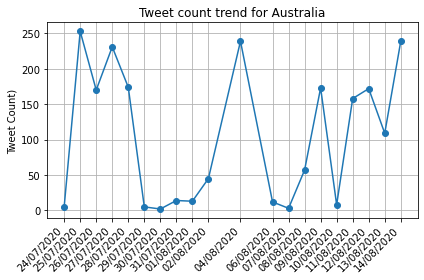

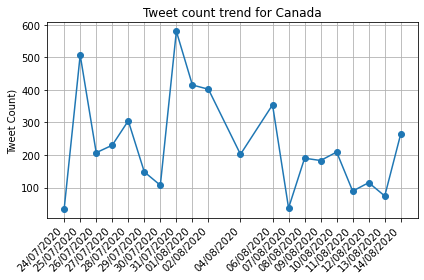

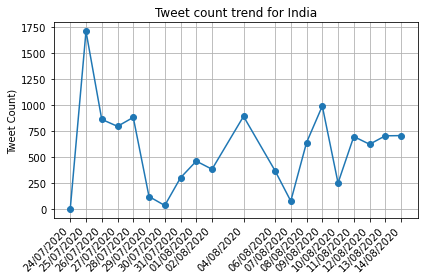

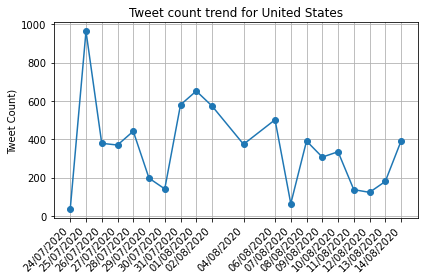

In [16]:
grp_df = df_top.groupby('user_location')
for i, grp in grp_df:
    dates = grp['just_date'].value_counts().sort_index().index
    counts = grp['just_date'].value_counts().sort_index().values
        
    plot_time_series(dates,counts,'Tweet count trend for '+i)

Let's plot top 20 users by the number of tweets.

In [17]:
plot_bar(df['user_name'].value_counts().index[0:20],
         df['user_name'].value_counts().values[0:20],
         "Top 20 Users by the number of tweets",
         "User",
         "Tweet Count")

Let's plot top 20 Tweeter sources by the number of tweets.

In [18]:
plot_bar(df['source'].value_counts().index[0:20],
         df['source'].value_counts().values[0:20],
         "Top 20 Tweeter Sources by the number of tweets",
         "Source",
         "Tweet Count")

There are hashtags used in tweets, let's find out popular covid hashtags and most buzzing words in tweets using wordcloud.

In [19]:
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

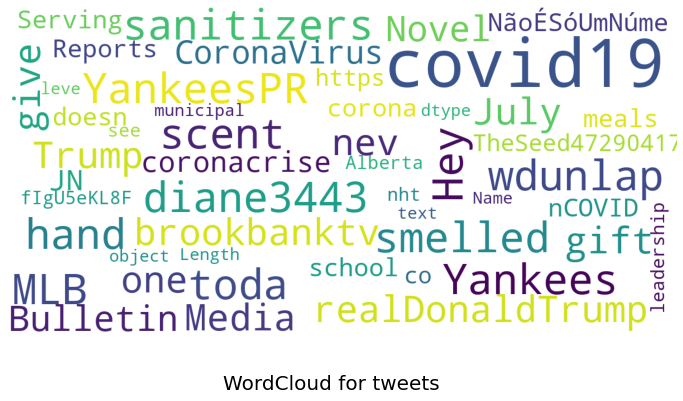

In [20]:
show_wordcloud(df['text'], "WordCloud for tweets")

Some processing of hashtags to remove commas and square brackets.

In [21]:
hashtags = list(df['hashtags'].dropna())

hashtags = [x.replace("'", '') for x in hashtags]
hashtags = [(re.sub(r'[^\w\s]','',x)).lower() for x in hashtags]


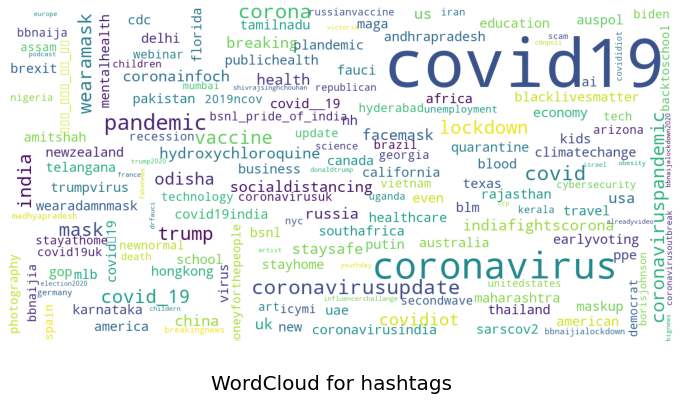

In [22]:
show_wordcloud(' '.join(hashtags),"WordCloud for hashtags")

# Sentimental Analysis

Let's start with loading the data.

In [310]:
data = pd.read_csv('../input/twitterdata/finalSentimentdata2.csv', encoding='"ISO-8859-1"')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [311]:
data.head()

,sentiment,text
0,sad,agree the poor in india are treated badly thei...
1,joy,if only i could have spent the with this cutie...
2,joy,will nature conservation remain a priority in ...
3,sad,coronavirus disappearing in italy show this to...
4,sad,uk records lowest daily virus death toll since...


Let's see the sentiment labels and their counts in data.

In [312]:
data['sentiment'].value_counts()

fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64

Let's define a function to remove the urls, html tags, punctuations and emojies from the text.

In [313]:
def clean_text(text):
    
    #remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    
    #remove html
    html_pattern = re.compile(r'<.*?>')
    text = html_pattern.sub(r'', text)
    
    #remove emojis
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
    
    #remove punctuations
    table = str.maketrans("", "", string.punctuation)
    text = text.translate(table)

    return text
#     #remove stopwords
#     stop = set(stopwords.words('english'))
#     text = [word.lower() for word in text.split() if word.lower() not in stop]

#     return ' '.join(text)

Let's replace label 'joy' with 1 and others with 0 to make it a binary classification task. 

Clean the text using the function clean_text defined above.

In [314]:
data['sentiment'] = data['sentiment'].apply(lambda x: int(x == 'joy'))
data['text'] = data['text'].apply(lambda x: clean_text(x))
df['text'] = df['text'].apply(lambda x: clean_text(x))

We cannot directly use textual data as input to our sequence model. Let's map each word in the tweet to an integer based on their count using Tokenizer from keras.

We need to have a fixed sized input for the model, here I am using maximum length as 20. Try with different values to find the best one. Usually a smaller value is recommended since it makes the input less sparse when padded with zeros.

In [315]:
def word_counter(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count  

counter = word_counter(data['text'].append(df['text']))
num_of_words = len(counter)
max_len = 20

t = Tokenizer(num_words = num_of_words)
t.fit_on_texts(data['text'].append(df['text']))

Split the data into train and test sets.

In [348]:
train_x, test_x, train_y, test_y = train_test_split(data['text'], data['sentiment'], test_size=0.1, random_state=30)

Tokenize and pad the train and test tweets.

In [349]:
train_tweets = t.texts_to_sequences(train_x)
train_tweets_padded = pad_sequences(train_tweets, maxlen=max_len, padding='post', truncating='post')

test_tweets = t.texts_to_sequences(test_x)
test_tweets_padded = pad_sequences(test_tweets, maxlen=max_len, padding='post', truncating='post')

### The model:

let's define our sequential model with following layers:

* Embedding Layer
* LSTM layer
* Dropout layer
* Dense layer

In [388]:
model = Sequential()
model.add(Embedding(num_of_words, 30, input_length = max_len))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [389]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 20, 30)            5162190   
_________________________________________________________________
lstm_57 (LSTM)               (None, 100)               52400     
_________________________________________________________________
dropout_57 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 101       
Total params: 5,214,691
Trainable params: 5,214,691
Non-trainable params: 0
_________________________________________________________________


In [390]:
data['sentiment'].value_counts()

0    2363
1     727
Name: sentiment, dtype: int64

As we have merged classes anger, fear and san into one, there is a class imbalance problem here, count of class 0 is higher than class 1. Let's handle it by assigning class_weights in the model.

In [391]:
weights = {0:1, 1:2}
history = model.fit(train_tweets_padded, train_y, epochs=5, validation_data = (test_tweets_padded,test_y),class_weight=weights,batch_size=40)

Epoch 1/5
70/70 [==============================] - 3s 47ms/step - loss: 0.7685 - accuracy: 0.7702 - val_loss: 0.4505 - val_accuracy: 0.7929
Epoch 2/5
70/70 [==============================] - 3s 39ms/step - loss: 0.3757 - accuracy: 0.8997 - val_loss: 0.3535 - val_accuracy: 0.8414
Epoch 3/5
70/70 [==============================] - 3s 40ms/step - loss: 0.1552 - accuracy: 0.9655 - val_loss: 0.4174 - val_accuracy: 0.8155
Epoch 4/5
70/70 [==============================] - 3s 40ms/step - loss: 0.0591 - accuracy: 0.9881 - val_loss: 0.4417 - val_accuracy: 0.8447
Epoch 5/5
70/70 [==============================] - 3s 40ms/step - loss: 0.0256 - accuracy: 0.9964 - val_loss: 0.4996 - val_accuracy: 0.8608


Accuracy is not a good measure for imbalanced class dataset, let's find f1 score to see how our model is performing on test data.

In [392]:
pred_y = model.predict_classes(test_tweets_padded)
print("F1 Score : ", f1_score(test_y,pred_y))

F1 Score :  0.7114093959731544


f1 score of 0.71 is good enough to go ahead. let's apply this model on some of the tweets from original dataset and see how it performs.

In [393]:
original_tweet = t.texts_to_sequences([df['text'][8]])
tweet_padded = pad_sequences(original_tweet, maxlen=max_len, padding='post', truncating='post')
res = model.predict_classes(tweet_padded)

In [394]:
print("Tweet :",df['text'][8])
print("Sentiment :",res[0][0])

Tweet : Praying for good health and recovery of ChouhanShivraj 
covid19
covidPositive
Sentiment : 1


In [395]:
original_tweet = t.texts_to_sequences([df['text'][644]])
tweet_padded = pad_sequences(original_tweet, maxlen=max_len, padding='post', truncating='post')
res = model.predict_classes(tweet_padded)

In [396]:
print("Tweet :",df['text'][644])
print("Sentiment :",res[0][0])

Tweet : And some of the Nationalists on here think she is different from other politicians 
 
She’s worse than Johnson COVID19
Sentiment : 0


Our model is able to correctly identify the sentiments of tweets from original dataset.

Let's predict sentiment of all tweets from original dataset and plot positive and negative sentiment counts.

In [397]:
original_tweets = t.texts_to_sequences(df['text'])
tweets_padded = pad_sequences(original_tweets, maxlen=max_len, padding='post', truncating='post')
res = model.predict_classes(tweets_padded)

In [398]:
res = [i[0] for i in res]

In [399]:
plot_bar(list(Counter(res).keys()),
         list(Counter(res).values()),
         "Count of Positive(1) and Negative(0) sentiments",
         "Sentiment",
         "Tweet Count")